# RNNs


Recurrent Neural Networks are supposed to be able to pick up temporal patterns. I want to get my hands around this. How complex a network do you need to pick up simple patterns? What about more complex patterns?

### Import dependencies

We'll work with synthetic data for now

In [62]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset


# We'll need this later... get it out the way now
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

## Straight Lines

Let's say we want our NN to figure out the pattern y=mx+c, where m=0.6 and c=2. This is literally a single weight (m) and bias (c), so a single neuron should be fine. Let's verify.

### Generate Test Data

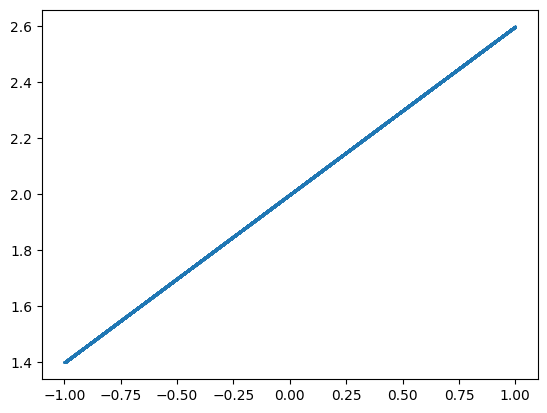

In [3]:
def split_dataset(dataset, percent_train=0.8):
    train_data, test_data = train_test_split(dataset, test_size=1-percent_train)
    test_data, val_data = train_test_split(test_data, test_size=0.5)
    return train_data, test_data, val_data

def to_data_loader(data, batch_size=32):
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

class StraightLineData:
    def __init__(self, m, c, n=100_000):
        self.m = m
        self.c = c
        self.n = n
        self.x_values = ((2 * np.random.rand(n)) - 1).astype(np.float32)
        self.y_values = m * self.x_values + c

        # Store normalization parameters
        self.x_min, self.x_max = self.x_values.min(), self.x_values.max()
        self.y_min, self.y_max = self.y_values.min(), self.y_values.max()

    def data(self):
        return np.column_stack((self.x_values, self.y_values))

    def normalized(self):
        x_normalized = (self.x_values - self.x_min) / (self.x_max - self.x_min)
        y_normalized = (self.y_values - self.y_min) / (self.y_max - self.y_min)
        return np.column_stack((x_normalized, y_normalized))

    def denormalize(self, normalized_data):
        x_normalized, y_normalized = normalized_data[:, 0], normalized_data[:, 1]
        x_denormalized = x_normalized * (self.x_max - self.x_min) + self.x_min
        y_denormalized = y_normalized * (self.y_max - self.y_min) + self.y_min
        return np.column_stack((x_denormalized, y_denormalized))

def plot_data(data):
    plt.scatter(data[:,0], data[:,1], s=0.1)
    plt.show()

def anon(): # I'll reuse this to keep global scope clean
    linear_data = StraightLineData(0.6, 2).data()
    plot_data(linear_data)
anon()

### Train the dumbest possible neural net

In [4]:
class SingleNeuronModel(nn.Module):
    def __init__(self):
        super(SingleNeuronModel, self).__init__()
        self.linear = nn.Linear(1, 1)
    def forward(self, x):
        x = self.linear(x)
        x = torch.relu(x) # should be fine since all values are positive
        return x

experiments = {} # keep this global and add all experiments to it

In [42]:

def train_model(model, train_loader, val_loader, learning_rate=0.0001, max_epochs=1000, patience=5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    epoch_losses, validation_losses = [], []
    best_val_loss = float('inf')
    trigger_times = 0

    for epoch in range(max_epochs):
        model.train()
        for batch in train_loader:
            x_train, y_train = batch[:, 0].unsqueeze(1), batch[:, 1].unsqueeze(1)
            x_train, y_train = x_train.to(device), y_train.to(device)
            # Forward pass
            y_predict = model(x_train)
            loss = criterion(y_predict, y_train)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_losses.append(loss.item())

        # Calculate validation loss
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x_val, y_val = batch[:, 0].unsqueeze(1), batch[:, 1].unsqueeze(1)
                x_val, y_val = x_val.to(device), y_val.to(device)
                y_predict = model(x_val)
                loss = criterion(y_predict, y_val)
                validation_loss += loss.item()

        validation_loss /= len(val_loader)
        validation_losses.append(validation_loss)
        print(f"Epoch [{epoch+1}/{max_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}")

        # Early stopping logic
        if  validation_loss < 0.00001:
            break
        elif validation_loss < best_val_loss:
            best_val_loss = validation_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping!")
                break

    plt.figure()
    plt.plot(epoch_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Epoch [1/1000], Training Loss: 0.0252, Validation Loss: 0.0349
Epoch [2/1000], Training Loss: 0.0289, Validation Loss: 0.0203
Epoch [3/1000], Training Loss: 0.0077, Validation Loss: 0.0085
Epoch [4/1000], Training Loss: 0.0011, Validation Loss: 0.0019
Epoch [5/1000], Training Loss: 0.0001, Validation Loss: 0.0001
Epoch [6/1000], Training Loss: 0.0000, Validation Loss: 0.0000


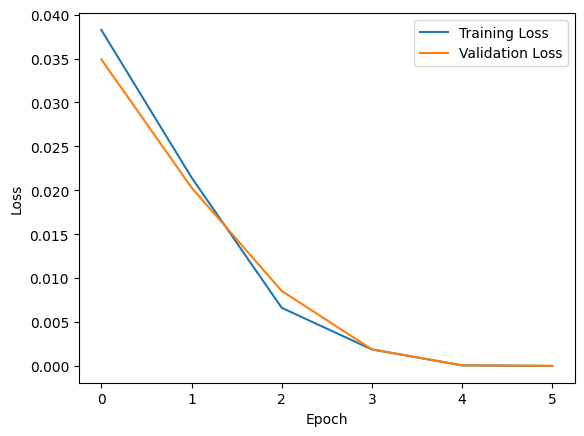

In [14]:
def anon():
    snn_model = SingleNeuronModel().to(device)
    linear_data = StraightLineData(0.6, 2).normalized()
    train_data, test_data, val_data = split_dataset(linear_data)
    train_loader = to_data_loader(train_data)
    val_loader = to_data_loader(val_data)
    learning_rate = 0.0001
    max_epochs = 1000

    experiments['Single Neuron Model'] = {
        'model': snn_model,
        'dataset': linear_data,
        'train_data': train_data,
        'test_data': test_data,
        'val_data': val_data,
        'learning_rate': learning_rate,
        'max_epochs': max_epochs,
    }

    train_model(snn_model, train_loader, val_loader, learning_rate=learning_rate, max_epochs=max_epochs)
anon()

### See if it worked

Our model should have learned a single weight of 0.6, and a single bias of 2. And if we plot it, we should see that line. Let's see.

Parameter containing:
tensor([[0.9997]], device='mps:0', requires_grad=True) Parameter containing:
tensor([0.0001], device='mps:0', requires_grad=True)
Test Loss: 0.0000


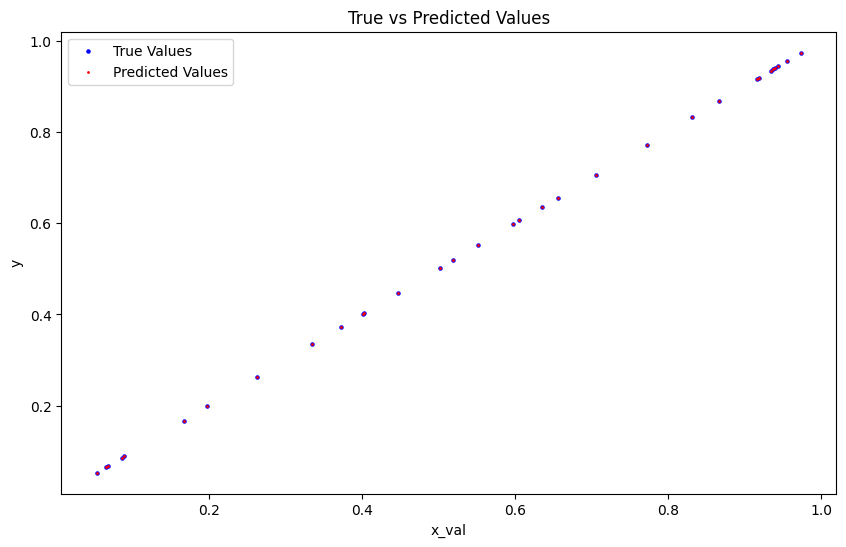

In [18]:
def print_predictions(x_val, y_val, y_predict):
    x_val_np = x_val.cpu().numpy()
    y_val_np = y_val.cpu().numpy()
    y_predict_np = y_predict.cpu().numpy()
    plt.figure(figsize=(10, 6))
    plt.scatter(x_val_np, y_val_np, s=5, color='blue', label='True Values')
    plt.scatter(x_val_np, y_predict_np, s=1, color='red', label='Predicted Values')
    plt.xlabel('x_val')
    plt.ylabel('y')
    plt.legend()
    plt.title('True vs Predicted Values')
    plt.show()

def anon():
    exp = experiments['Single Neuron Model']
    model = exp['model']
    print(model.linear.weight, model.linear.bias)
    test_loader = to_data_loader(exp['test_data'])
    batch = next(iter(test_loader))
    x_val, y_val = batch[:, 0].unsqueeze(1), batch[:, 1].unsqueeze(1)

    model.eval()
    with torch.no_grad():
        y_predict = model(x_val.to(device))
        loss = nn.MSELoss()(y_predict, y_val.to(device))
        print(f"Test Loss: {loss.item():.4f}")
        print_predictions(x_val, y_val, y_predict)
anon()

## Sine Waves

Let's try something a little harder. How complicated a network do we need to approximate `y = sin(x)`?

### Generate Test data

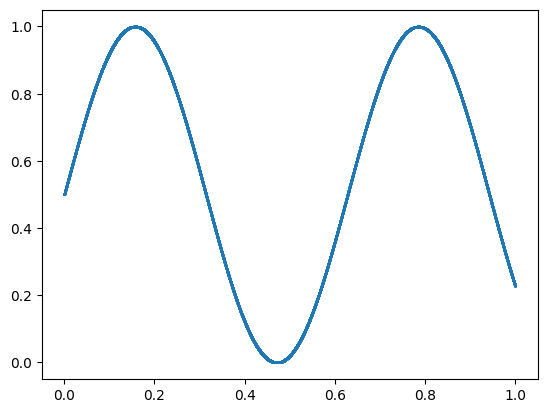

In [52]:
class SineData:
    def __init__(self, m, c, n=100_000, dist_max=10, offset=0):
        self.m = m
        self.c = c
        self.n = n
        self.x_values = ((dist_max * np.random.rand(n)) - offset).astype(np.float32)
        self.y_values = m * np.sin(self.x_values) + c

        # Store normalization parameters
        self.x_min, self.x_max = self.x_values.min(), self.x_values.max()
        self.y_min, self.y_max = self.y_values.min(), self.y_values.max()

    def data(self):
        return np.column_stack((self.x_values, self.y_values))

    def normalized(self):
        x_normalized = (self.x_values - self.x_min) / (self.x_max - self.x_min)
        y_normalized = (self.y_values - self.y_min) / (self.y_max - self.y_min)
        return np.column_stack((x_normalized, y_normalized))

    def denormalize(self, normalized_data):
        x_normalized, y_normalized = normalized_data[:, 0], normalized_data[:, 1]
        x_denormalized = x_normalized * (self.x_max - self.x_min) + self.x_min
        y_denormalized = y_normalized * (self.y_max - self.y_min) + self.y_min
        return np.column_stack((x_denormalized, y_denormalized))

def anon():
    sine_data = SineData(1, 0).normalized()
    plot_data(sine_data)
anon()

### Train a dumb net again

Of course it won't work. But *how* won't it work?

Personally, I expect it to converge on `y=0x+0.5`, judging from the chart above.

Epoch [1/1000], Training Loss: 0.0412, Validation Loss: 0.1177
Epoch [2/1000], Training Loss: 0.1284, Validation Loss: 0.1139
Epoch [3/1000], Training Loss: 0.0929, Validation Loss: 0.1119
Epoch [4/1000], Training Loss: 0.0999, Validation Loss: 0.1111
Epoch [5/1000], Training Loss: 0.0973, Validation Loss: 0.1107
Epoch [6/1000], Training Loss: 0.1148, Validation Loss: 0.1106
Epoch [7/1000], Training Loss: 0.1481, Validation Loss: 0.1106
Epoch [8/1000], Training Loss: 0.0910, Validation Loss: 0.1104
Epoch [9/1000], Training Loss: 0.1282, Validation Loss: 0.1105
Epoch [10/1000], Training Loss: 0.1002, Validation Loss: 0.1105
Epoch [11/1000], Training Loss: 0.1199, Validation Loss: 0.1105
Epoch [12/1000], Training Loss: 0.0525, Validation Loss: 0.1104
Epoch [13/1000], Training Loss: 0.1291, Validation Loss: 0.1105
Epoch [14/1000], Training Loss: 0.0703, Validation Loss: 0.1104
Epoch [15/1000], Training Loss: 0.1254, Validation Loss: 0.1105
Epoch [16/1000], Training Loss: 0.0610, Validatio

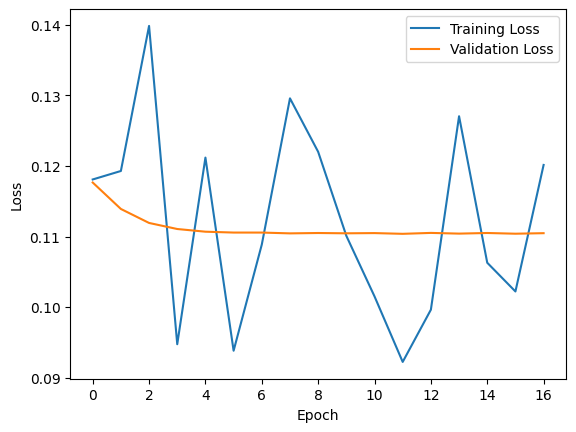

In [31]:
def anon():
    snn_model_for_sines = SingleNeuronModel().to(device)
    sine_data = SineData(1, 0).normalized()
    train_data, test_data, val_data = split_dataset(sine_data)
    train_loader = to_data_loader(train_data)
    val_loader = to_data_loader(val_data)
    learning_rate = 0.0001
    max_epochs = 1000

    experiments['Single Neuron Model for Sines'] = {
        'model': snn_model_for_sines,
        'dataset': sine_data,
        'train_data': train_data,
        'test_data': test_data,
        'val_data': val_data,
        'learning_rate': learning_rate,
        'max_epochs': max_epochs,
    }

    train_model(snn_model_for_sines, train_loader, val_loader, learning_rate=learning_rate, max_epochs=max_epochs)
anon()

### See if it worked (it won't have)

In [32]:
def print_model_outputs(model, test_loader, batches=1):
    xs = torch.empty(0, 1).to(device)
    ys = torch.empty(0, 1).to(device)
    preds = torch.empty(0, 1).to(device)
    model.eval()
    with torch.no_grad():
        batch_no = 0
        for batch in test_loader:
            batch_no += 1
            x_val, y_val = batch[:, 0].unsqueeze(1).to(device), batch[:, 1].unsqueeze(1).to(device)
            y_predict = model(x_val).to(device)
            xs = torch.cat((xs, x_val), dim=0)
            ys = torch.cat((ys, y_val), dim=0)
            preds = torch.cat((preds, y_predict), dim=0)
            if batch_no == batches:
                break
    print_predictions(xs, ys, preds)

Parameter containing:
tensor([[-0.0796]], device='mps:0', requires_grad=True) Parameter containing:
tensor([0.6303], device='mps:0', requires_grad=True)


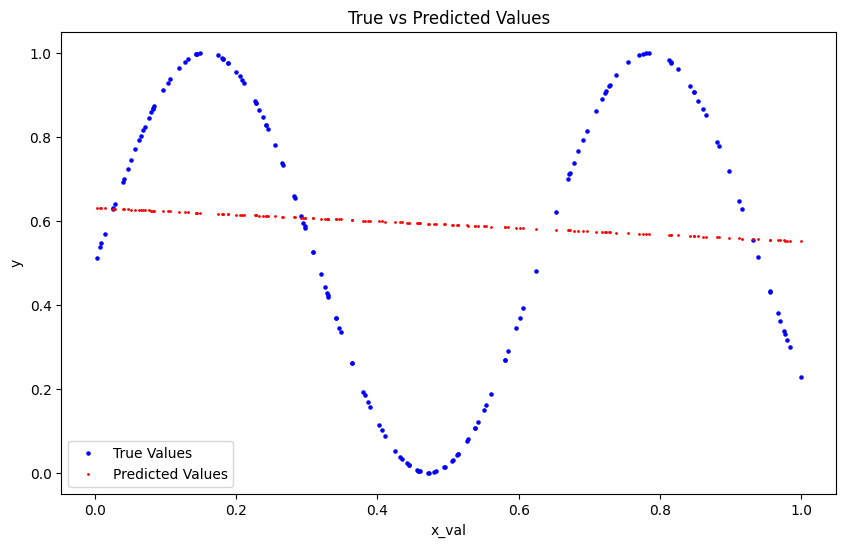

In [33]:

def anon():
    exp = experiments['Single Neuron Model for Sines']
    model = exp['model']
    print(model.linear.weight, model.linear.bias)
    print_model_outputs(model, to_data_loader(exp['test_data']), batches=5)
anon()

Hah! I was pretty close! Clearly there's no way our linear net can approximate a sine wave. Let's try a non-linear model.

### Something more sophisticated

Here's something that has 2,600 (50 + 50x50 + 50) params, each with a `tanh` that is *vaguely like* a sin wave. It could theoretically tune to find a decent approximation over some interval. Let's see how it does.

In [34]:
class SineApproximator(nn.Module):
    def __init__(self):
        super(SineApproximator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.net(x)

Epoch [1/1000], Training Loss: 0.1385, Validation Loss: 0.1101
Epoch [2/1000], Training Loss: 0.1068, Validation Loss: 0.0930
Epoch [3/1000], Training Loss: 0.0556, Validation Loss: 0.0600
Epoch [4/1000], Training Loss: 0.0841, Validation Loss: 0.0405
Epoch [5/1000], Training Loss: 0.0303, Validation Loss: 0.0231
Epoch [6/1000], Training Loss: 0.0051, Validation Loss: 0.0078
Epoch [7/1000], Training Loss: 0.0011, Validation Loss: 0.0019
Epoch [8/1000], Training Loss: 0.0010, Validation Loss: 0.0005
Epoch [9/1000], Training Loss: 0.0001, Validation Loss: 0.0001
Epoch [10/1000], Training Loss: 0.0001, Validation Loss: 0.0000
Epoch [11/1000], Training Loss: 0.0000, Validation Loss: 0.0000
Epoch [12/1000], Training Loss: 0.0000, Validation Loss: 0.0000
Epoch [13/1000], Training Loss: 0.0000, Validation Loss: 0.0000


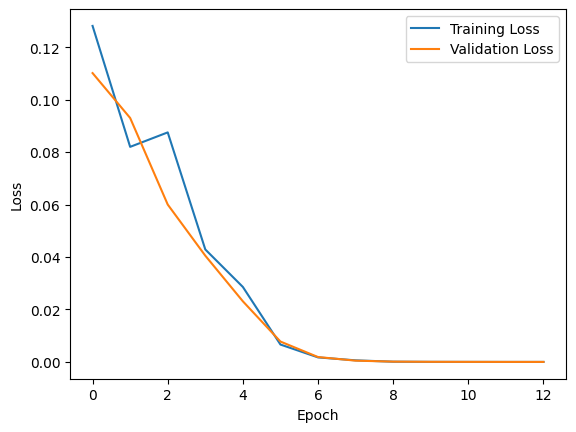

In [35]:
def anon():
    sine_approximator = SineApproximator().to(device)
    sine_data = SineData(1, 0).normalized()
    train_data, test_data, val_data = split_dataset(sine_data)
    train_loader = to_data_loader(train_data)
    val_loader = to_data_loader(val_data)
    learning_rate = 0.0001
    max_epochs = 1000

    experiments['MLP-Tanh'] = {
        'model': sine_approximator,
        'dataset': sine_data,
        'train_data': train_data,
        'test_data': test_data,
        'val_data': val_data,
        'learning_rate': learning_rate,
        'max_epochs': max_epochs,
    }

    train_model(sine_approximator, train_loader, val_loader, learning_rate=learning_rate, max_epochs=max_epochs)
anon()

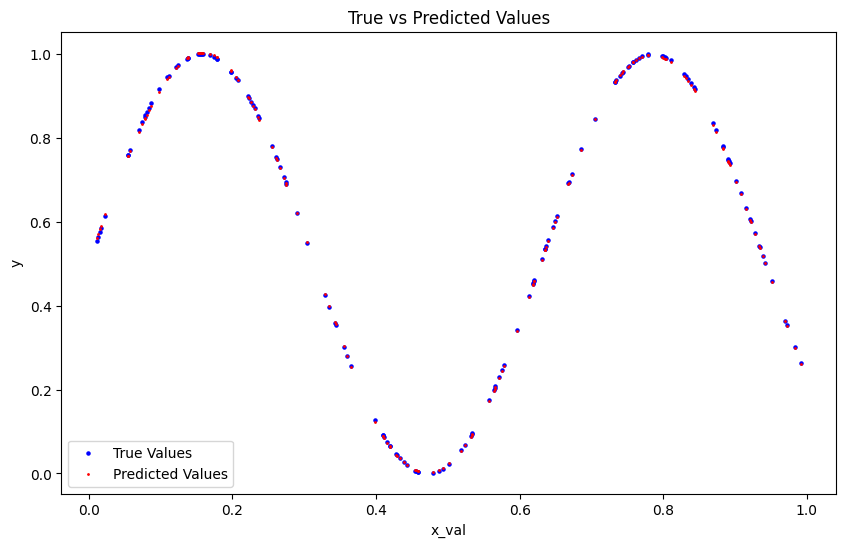

In [36]:
def anon():
    exp = experiments['MLP-Tanh']
    model = exp['model']
    print_model_outputs(model, to_data_loader(exp['test_data']), batches=5)
anon()

That worked! Though I wonder how far I can push this. What if I include 10 peaks instead of two? Let's use the same SineApproximator model and see how far I can go...

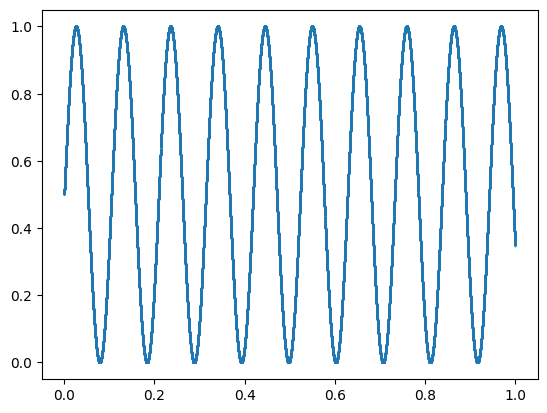

In [43]:
def anon():
    sine_data_10 = SineData(1, 0, n=100_000, dist_max=60).normalized()
    train_sine_data, test_sine_data, val_sine_data = split_dataset(sine_data_10)
    experiments['MLP-Tanh-DenseData'] = {
        'model': SineApproximator().to(device),
        'dataset': sine_data_10,
        'train_data': train_sine_data,
        'test_data': test_sine_data,
        'val_data': val_sine_data,
        'learning_rate': 0.0001,
        'max_epochs': 1000,
    }
    plot_data(sine_data_10)
anon()

Epoch [1/1000], Training Loss: 0.1042, Validation Loss: 0.1213
Epoch [2/1000], Training Loss: 0.0591, Validation Loss: 0.1215
Epoch [3/1000], Training Loss: 0.1251, Validation Loss: 0.1213
Epoch [4/1000], Training Loss: 0.0982, Validation Loss: 0.1217
Epoch [5/1000], Training Loss: 0.1083, Validation Loss: 0.1213
Epoch [6/1000], Training Loss: 0.1176, Validation Loss: 0.1219
Epoch [7/1000], Training Loss: 0.0843, Validation Loss: 0.1213
Epoch [8/1000], Training Loss: 0.1121, Validation Loss: 0.1215
Epoch [9/1000], Training Loss: 0.1082, Validation Loss: 0.1214
Epoch [10/1000], Training Loss: 0.1042, Validation Loss: 0.1213
Epoch [11/1000], Training Loss: 0.1101, Validation Loss: 0.1216
Epoch [12/1000], Training Loss: 0.1490, Validation Loss: 0.1213
Epoch [13/1000], Training Loss: 0.1212, Validation Loss: 0.1215
Epoch [14/1000], Training Loss: 0.1254, Validation Loss: 0.1215
Epoch [15/1000], Training Loss: 0.1552, Validation Loss: 0.1217
Epoch [16/1000], Training Loss: 0.1250, Validatio

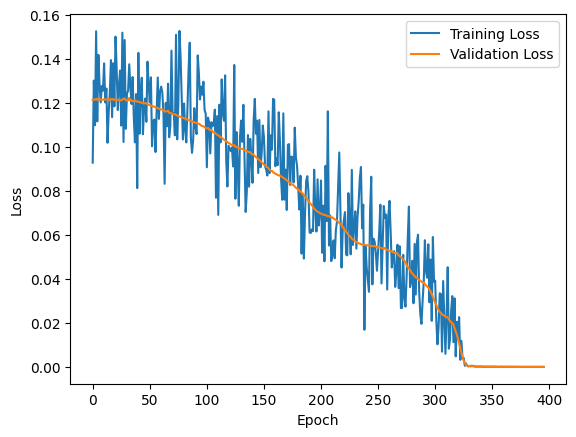

In [45]:
def anon():
    exp = experiments['MLP-Tanh-DenseData']
    train_sine_loader = to_data_loader(exp['train_data'])
    val_sine_loader = to_data_loader(exp['val_data'])
    model = exp['model']
    learning_rate = exp['learning_rate'] = 0.0001
    patience = exp['patience'] = 10
    train_model(
        model,
        train_sine_loader,
        val_sine_loader,
        learning_rate=learning_rate,
        max_epochs=1000,
        patience=patience
    )
anon()


Holy moly! It got there in the end but... at what cost? 51 mins vs 2.5 mins (20x increase 😱)! And 400 epochs vs 23!

Let's go ahead and print the test output, and then have a think about what's going on.

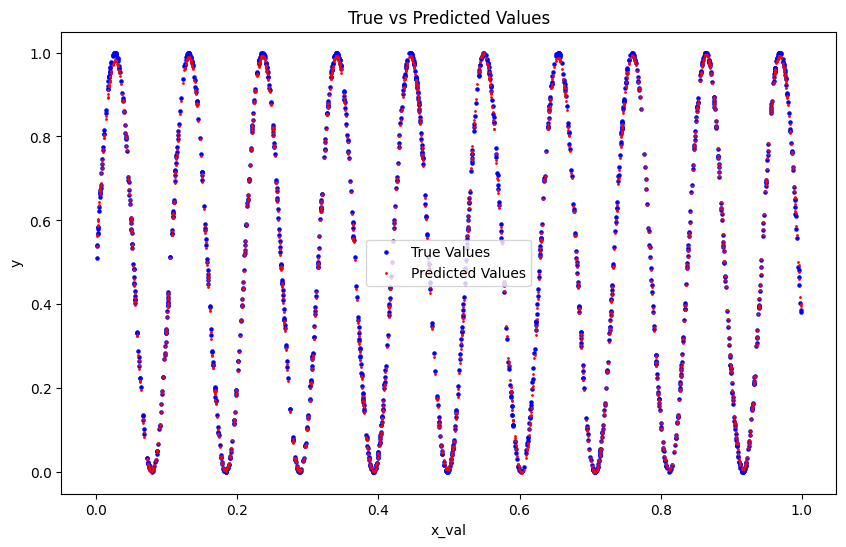

In [46]:
def anon():
    exp = experiments['MLP-Tanh-DenseData']
    print_model_outputs(exp['model'], to_data_loader(exp['test_data']), batches=50)
anon()

Results = Pretty dang good! Training = 💩

It should *not* take a modern computer 45 minutes and 400 epochs to learn `y=sinx`. Let's try to be smarter

I have a couple of theories:
- I think normalizing might be hurting us. Intuitively, say we had 100 peaks, and we normalized our data so they were all squeezed into the space between 0-1, it would be pretty hard to tell what's going on. At a smaller scale, I think that's what might be happening here. I want to try this with *unnormalized* data and see what happens. I expect it to train faster since the patterns should be easier to "see". I may *standardize* so the data is distributed around zero on the x axis, but will otherwise leave it the same.
- I also think this might start to be the point at which an LSTM structure might help. I have to imagine that with the correct params, this should be able to learn a pattern like y=sin(x) trivially. Let's also make some ideas up about how that might work and have a go.

## Normalization

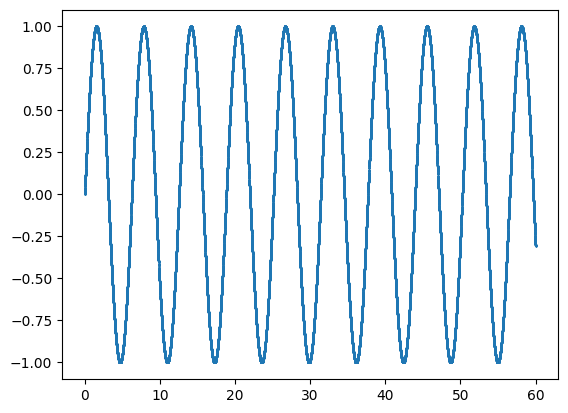

In [49]:
def anon():
    data = SineData(1, 0, n=100_000, dist_max=60).data()
    train_data, test_data, val_data = split_dataset(data)
    experiments['MLP-Tanh-DenseData-Unnormalized'] = {
        'model': SineApproximator().to(device),
        'dataset': data,
        'train_data': train_data,
        'test_data': test_data,
        'val_data': val_data,
        'learning_rate': 0.0001,
        'max_epochs': 1000,
        'patience': 10,
    }
    plot_data(data)
anon()

Note that just the x axis is different. Everything else is the same. I think this should achieve the same result, but ideally in fewer than 50 mins and 400 epochs 🤦‍♂️

In [50]:
def anon():
    exp = experiments['MLP-Tanh-DenseData-Unnormalized']
    train_model(
        exp['model'],
        to_data_loader(exp['train_data']),
        to_data_loader(exp['val_data']),
        learning_rate=exp['learning_rate'],
        max_epochs=1000,
        patience=exp['patience']
    )
anon()

Epoch [1/1000], Training Loss: 0.7122, Validation Loss: 0.4862
Epoch [2/1000], Training Loss: 0.4598, Validation Loss: 0.4805
Epoch [3/1000], Training Loss: 0.4860, Validation Loss: 0.4772
Epoch [4/1000], Training Loss: 0.3921, Validation Loss: 0.4735
Epoch [5/1000], Training Loss: 0.4536, Validation Loss: 0.4701
Epoch [6/1000], Training Loss: 0.3823, Validation Loss: 0.4673
Epoch [7/1000], Training Loss: 0.3850, Validation Loss: 0.4703
Epoch [8/1000], Training Loss: 0.5388, Validation Loss: 0.4635
Epoch [9/1000], Training Loss: 0.3937, Validation Loss: 0.4645
Epoch [10/1000], Training Loss: 0.5240, Validation Loss: 0.4629
Epoch [11/1000], Training Loss: 0.4561, Validation Loss: 0.4604
Epoch [12/1000], Training Loss: 0.4531, Validation Loss: 0.4633
Epoch [13/1000], Training Loss: 0.4276, Validation Loss: 0.4591
Epoch [14/1000], Training Loss: 0.3677, Validation Loss: 0.4589
Epoch [15/1000], Training Loss: 0.5994, Validation Loss: 0.4602
Epoch [16/1000], Training Loss: 0.4379, Validatio

KeyboardInterrupt: 

Nope! Normalizing definitely helped! After 491 epochs we still had a loss of 0.18, which is really not great. We can plot what this looks like for funsies. 

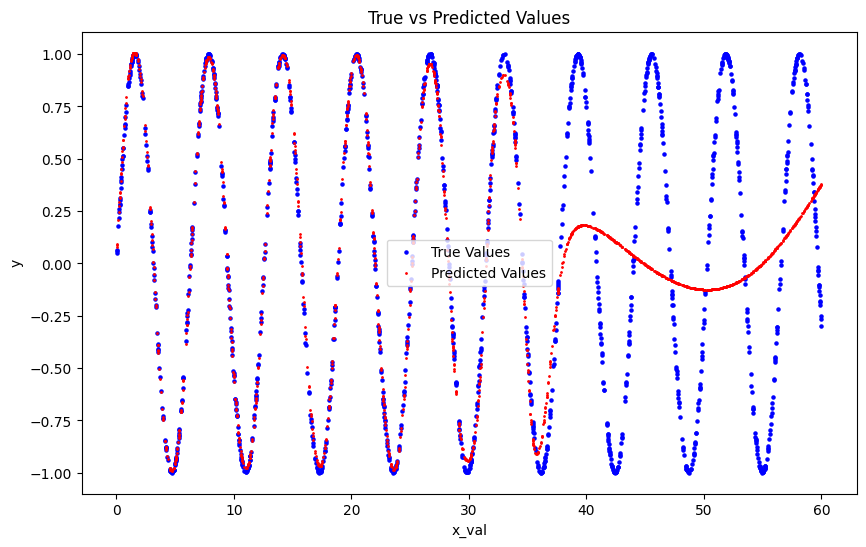

In [51]:
def anon():
    exp = experiments['MLP-Tanh-DenseData-Unnormalized']
    print_model_outputs(exp['model'], to_data_loader(exp['test_data']), batches=50)
anon()

Huh! honestly pretty interesting! I guess the amount of information is the same in both cases but if x-values are quite large we end up with neurons set to something like `tanh(w(x)+b)`, then `x` being 60 is indistinguishable from `x` being a small value like 2, leading to a vanishing gradient. If I had more patience I would test this again with values from -60 to 60 to verify that the function is approximated much better closer to 0.

Actually... Y'know... let's do that...

### Shifting Left

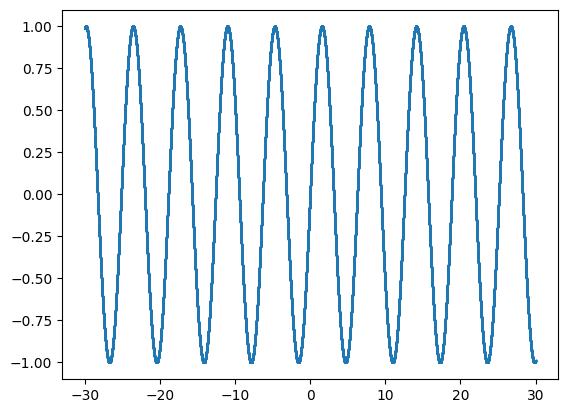

In [54]:
def anon():
    data = SineData(1, 0, n=100_000, dist_max=60, offset=30).data() # Shifted left by 30
    # all other params are the same except for epochs (since we bailed out early last time)
    train_data, test_data, val_data = split_dataset(data)
    experiments['MLP-Tanh-DenseData-Unnormalized-Shifted'] = {
        'model': SineApproximator().to(device),
        'dataset': data,
        'train_data': train_data,
        'test_data': test_data,
        'val_data': val_data,
        'learning_rate': 0.0001,
        'max_epochs': 500, # don't train any more than last time
        'patience': 10,
    }
    plot_data(data)
anon()

In [55]:
def anon():
    exp = experiments['MLP-Tanh-DenseData-Unnormalized-Shifted']
    train_model(
        exp['model'],
        to_data_loader(exp['train_data']),
        to_data_loader(exp['val_data']),
        learning_rate=exp['learning_rate'],
        max_epochs=exp['max_epochs'],
        patience=exp['patience']
    )
anon()

Epoch [1/500], Training Loss: 0.3144, Validation Loss: 0.4663
Epoch [2/500], Training Loss: 0.4011, Validation Loss: 0.4565
Epoch [3/500], Training Loss: 0.5152, Validation Loss: 0.4460
Epoch [4/500], Training Loss: 0.4975, Validation Loss: 0.4428
Epoch [5/500], Training Loss: 0.3210, Validation Loss: 0.4349
Epoch [6/500], Training Loss: 0.5045, Validation Loss: 0.4359
Epoch [7/500], Training Loss: 0.4092, Validation Loss: 0.4312
Epoch [8/500], Training Loss: 0.5983, Validation Loss: 0.4320
Epoch [9/500], Training Loss: 0.5511, Validation Loss: 0.4279
Epoch [10/500], Training Loss: 0.5328, Validation Loss: 0.4227
Epoch [11/500], Training Loss: 0.3274, Validation Loss: 0.4220
Epoch [12/500], Training Loss: 0.3622, Validation Loss: 0.4209
Epoch [13/500], Training Loss: 0.5581, Validation Loss: 0.4187
Epoch [14/500], Training Loss: 0.4069, Validation Loss: 0.4211
Epoch [15/500], Training Loss: 0.4125, Validation Loss: 0.4161
Epoch [16/500], Training Loss: 0.4549, Validation Loss: 0.4149
E

KeyboardInterrupt: 

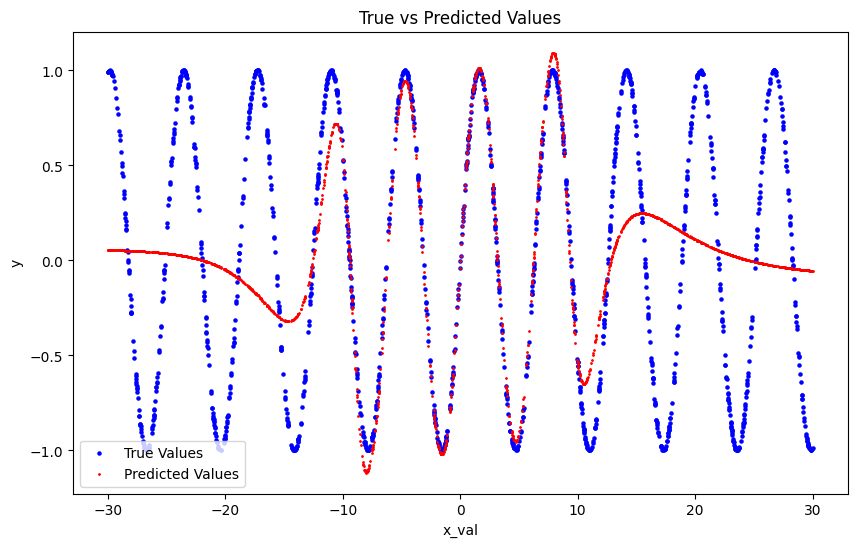

In [56]:
def anon():
    exp = experiments['MLP-Tanh-DenseData-Unnormalized-Shifted']
    print_model_outputs(exp['model'], to_data_loader(exp['test_data']), batches=50)
anon()

Haha! Yep... pretty-much as expected. Data closer to zero probably just has much more reasonable gradients 🤷‍♂️

## LSTMs

To make this little experiment work with LSTMs we'll need to adjust our sine-wave data to be purely sequential. So instead of randomly initializing x values between 0 and dist_max, we'll use `np.linspace`, and then try to use sliding windows of various lengths as the inputs.

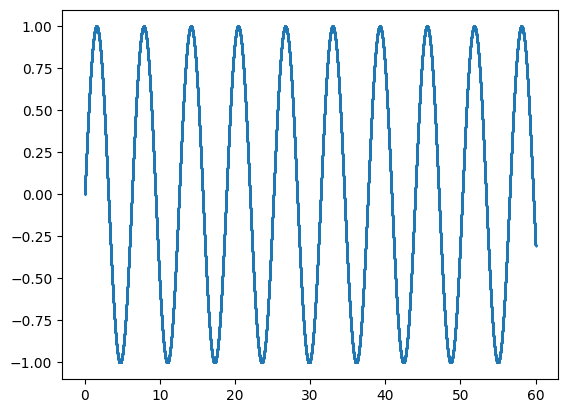

In [61]:
class SineDataEven:
    def __init__(self, m, c, n=100_000, dist_max=10, offset=0):
        self.m = m
        self.c = c
        self.n = n
        self.x_values = np.linspace(0, dist_max, n).astype(np.float32) - offset
        self.y_values = m * np.sin(self.x_values) + c

        # Store normalization parameters
        self.x_min, self.x_max = self.x_values.min(), self.x_values.max()
        self.y_min, self.y_max = self.y_values.min(), self.y_values.max()

    def data(self):
        return np.column_stack((self.x_values, self.y_values))

    def normalized(self):
        x_normalized = (self.x_values - self.x_min) / (self.x_max - self.x_min)
        y_normalized = (self.y_values - self.y_min) / (self.y_max - self.y_min)
        return np.column_stack((x_normalized, y_normalized))

    def denormalize(self, normalized_data):
        x_normalized, y_normalized = normalized_data[:, 0], normalized_data[:, 1]
        x_denormalized = x_normalized * (self.x_max - self.x_min) + self.x_min
        y_denormalized = y_normalized * (self.y_max - self.y_min) + self.y_min
        return np.column_stack((x_denormalized, y_denormalized))

def prepare_sine_data(sine_data, seq_length):
    """
    Prepare data by dividing into sequences of length `seq_length` and
    predicting the next value in the sequence.
    """
    data = sine_data.normalized()
    x_values, y_values = data[:, 0], data[:, 1]

    sequences = []
    targets = []

    # Create sequences and corresponding next value (target)
    for i in range(len(x_values) - seq_length):
        sequences.append(y_values[i:i + seq_length])  # Input sequence
        targets.append(y_values[i + seq_length])      # Target is the next value

    sequences = np.array(sequences).reshape(-1, seq_length, 1)  # Shape: (batch_size, seq_length, 1)
    targets = np.array(targets).reshape(-1, 1)                  # Shape: (batch_size, 1)

    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

def anon():
    sine_data = SineDataEven(1, 0, 100_000, dist_max=60, offset=0).data()
    plot_data(sine_data)
anon()

In [78]:
class SineApproximatorLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]
        x = self.fc(x)
        return x

In [104]:

def train_sequential_model(model, train_loader, learning_rate=0.0001, max_epochs=1000, patience=5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    epoch_losses, validation_losses = [], []
    best_loss_percent = float('inf')
    trigger_times = 0

    for epoch in range(max_epochs):
        model.train()
        epoch_loss = 0
        for seqs, targets in train_loader:
            # Forward pass
            y_predict = model(seqs.to(device))
            loss = criterion(y_predict, targets.to(device))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_losses.append(loss.item())
        loss_percent = epoch_loss/len(train_loader)

        msg = f'Epoch {epoch+1}/{max_epochs}, Loss: {loss_percent:.7f}'
        if loss_percent < 0.00001:
            print(loss_percent)
            break
        elif loss_percent < best_loss_percent:
            best_loss_percent = loss_percent
            trigger_times = 0
            print(msg)
        else:
            trigger_times += 1
            print(msg + '*')
            if trigger_times >= patience:
                print("Early stopping!")
                break

    plt.figure()
    plt.plot(epoch_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [105]:
def anon():

    data = SineDataEven(1, 0, 100_000, dist_max=60, offset=0)

    seq_length = 50
    sequences, targets = prepare_sine_data(data, seq_length)

    train_percent = 0.8
    train_seq, train_targets = sequences[:int(train_percent * len(sequences))], targets[:int(train_percent * len(sequences))]
    test_seq, test_targets = sequences[int(train_percent * len(sequences)):], targets[int(train_percent * len(sequences)):]

    train_dataset = TensorDataset(train_seq, train_targets)
    test_dataset = TensorDataset(test_seq, test_targets)

    hidden_size = 16
    num_layers = 1
    experiments['LSTM-Sequential'] = {
        'model': SineApproximatorLSTM(hidden_size=hidden_size, num_layers=num_layers).to(device),
        'dataset': data,
        'train_data': train_dataset,
        'test_data': test_dataset,
        'learning_rate': 0.0001,
        'max_epochs': 500, # don't train any more than last time
        'patience': 3,
    }
anon()

Epoch 1/500, Loss: 0.0287555
Epoch 2/500, Loss: 0.0000486
7.075467690628211e-06


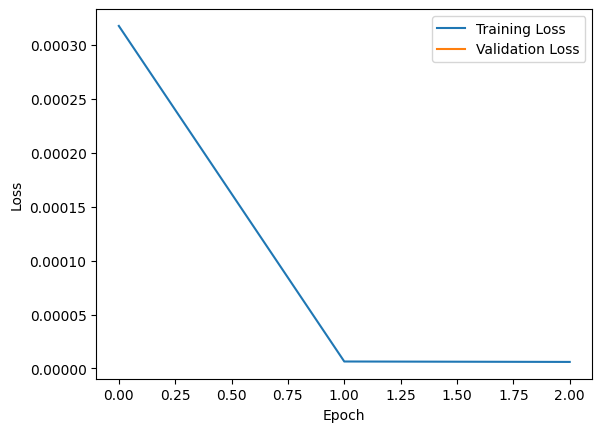

In [106]:
def anon():
    exp = experiments['LSTM-Sequential']
    train_sequential_model(
        exp['model'],
        to_data_loader(exp['train_data']),
        learning_rate=exp['learning_rate'],
        max_epochs=exp['max_epochs'],
        patience=exp['patience']
    )
anon()

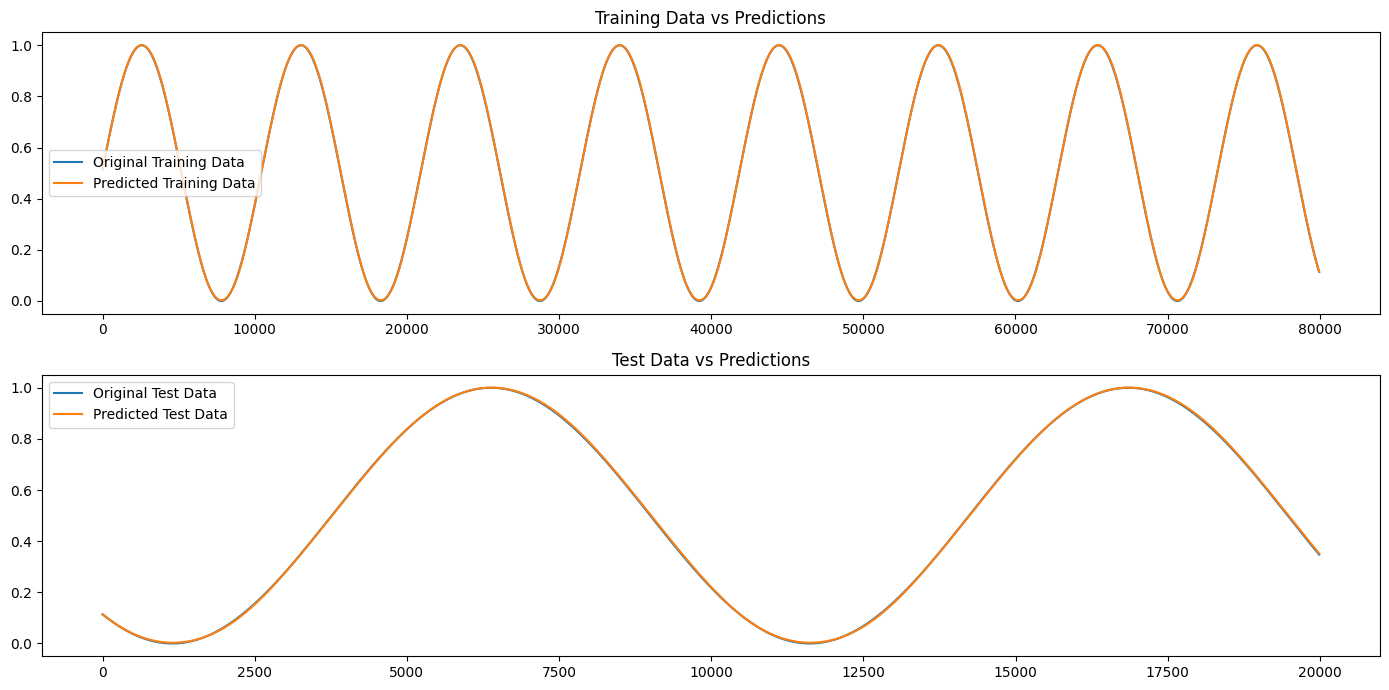

In [101]:
def plot_predictions2(model, train_loader, test_loader, seq_length):
    model.eval()
    with torch.no_grad():
        # Predict on training data
        train_predictions = []
        train_targets = []
        for seq, target in train_loader:
            seq = seq.to(device)
            output = model(seq)
            train_predictions.extend(output.cpu().numpy())
            train_targets.extend(target.cpu().numpy())

        # Predict on test data
        test_predictions = []
        test_targets = []
        for seq, target in test_loader:
            seq = seq.to(device)
            output = model(seq)
            test_predictions.extend(output.cpu().numpy())
            test_targets.extend(target.cpu().numpy())

    # Plotting
    plt.figure(figsize=(14, 7))

    # Plot training data
    plt.subplot(2, 1, 1)
    plt.plot(train_targets, label='Original Training Data')
    plt.plot(train_predictions, label='Predicted Training Data')
    plt.title('Training Data vs Predictions')
    plt.legend()

    # Plot test data
    plt.subplot(2, 1, 2)
    plt.plot(test_targets, label='Original Test Data')
    plt.plot(test_predictions, label='Predicted Test Data')
    plt.title('Test Data vs Predictions')
    plt.legend()

    plt.tight_layout()
    plt.show()

def anon():
    # Prepare data
    data = SineDataEven(1, 0, 100_000, dist_max=60, offset=0)
    seq_length = 50
    sequences, targets = prepare_sine_data(data, seq_length)

    train_percent = 0.8
    train_seq, train_targets = sequences[:int(train_percent * len(sequences))], targets[:int(train_percent * len(sequences))]
    test_seq, test_targets = sequences[int(train_percent * len(sequences)):], targets[int(train_percent * len(sequences)):]

    train_dataset = TensorDataset(train_seq, train_targets)
    test_dataset = TensorDataset(test_seq, test_targets)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Assuming the model is already trained and stored in experiments
    model = experiments['LSTM-Sequential']['model']

    # Plot predictions
    plot_predictions2(model, train_loader, test_loader, seq_length)
anon()

Wild! Job done in like 1 min with 2 epochs! Clearly these things are awesome at sequential patterns. Next up, let's look at a few 'real' datasets.